<div style='text-align:center'>
<br>
    <h1>Independent Component Analysis (ICA)</h1><br>
<br>
<br></div>

This notebook is a quick overview of how ICA works and how to apply it to denoise images. It lacks a lot of detail but includes some links to supplement.


## What is ICA:
- Separating a multivariate signal into additive subcomponents [Wikipedia](https://en.wikipedia.org/wiki/Independent_component_analysis)
- ICA is often introduced with the cocktail party problem.

### Cocktail party problem:
- People are talking at a cocktail party and being recorded by multiple microphones. The microphones are picking up all conversation and noise at the party. Is there a way to separate the signals from each person in the conversation from the rest of the noise?

For simplicity sake we'll assume there are 2 people talking and 2 microphones recording from different positions. No other complexity is added to this problem. Each microphone picks up both conversations but with different measurements of the conversation depending on how close the microphone is to each speaker and how loud the speakers are talking.

The recordings are stored as 
$X = 
\begin{bmatrix}
x_{1,1} && x_{1,2} && \dots && x_{1,N}\\ 
x_{2,1} && x_{2,2} && \dots && x_{2,N}\\
\end{bmatrix}$

The signals we want to recover (each persons voice in the conversation) are represented by $S$.

With a mixing matrix $W$ we could represent the signals as $S = WX$, where the values of $W$ allow us to separate the signals from $X$.

If W is known S can be solved by $SW^{-1}=X$, so we need to solve for W.

In this simplified problem, we have 2 recordings so X is an 2 x N matrix where each recording is a column vector of length N.

$X = 
\begin{bmatrix}
x_{1,1} && x_{1,2} && \dots && x_{1,N}\\ 
x_{2,1} && x_{2,2} && \dots && x_{2,N}\\
\end{bmatrix}$

$W$ will be a 2x2 matrix

$W =
\begin{bmatrix}
w_{1,1} && w_{2,1}\\ 
w_{1,2} && w_{2,2}\\ 
\end{bmatrix}$

$S$ will therefore be a 2xN vector, one row for each signal with N values.

$S =
\begin{bmatrix}
s_{1,1} && s_{1,2} && \dots && s_{1,N} \\ 
s_{2,1} && s_{2,2} && \dots && s_{2,N} \\ 
\end{bmatrix}$

So all together

$
\begin{bmatrix}
s_{1,1} && s_{1,2} && \dots && s_{1,N} \\ 
s_{2,1} && s_{2,2} && \dots && s_{2,N} \\ 
\end{bmatrix}
= 
\begin{bmatrix}
w_{1,1} && w_{2,1}\\ 
w_{1,2} && w_{2,2}\\ 
\end{bmatrix}
\begin{bmatrix}
x_{1,1} && x_{1,2} && \dots && x_{1,N}\\ 
x_{2,1} && x_{2,2} && \dots && x_{2,N}\\
\end{bmatrix}$

Instead of audio recorings, which there are plenty of examples for, we're going to use images, which is another way ICA can be used.

There are many ways to perform ICA, with a popular algorithm being Fast ICA. I'd highly suggest reading this paper, [Independent Component Analysis: Algorithms and Applications](https://www.cs.helsinki.fi/u/ahyvarin/papers/NN00new.pdf), for a detailed explanation.

The Fast ICA algorithm boils down to this:
1. Preprocess the data (center and whiten)
2. Randomly initialize a weight vector such that the L2 norm of the weights is 1
3. Solve by maximizing the negative entropy


## Preprocessing

To make use of ICA the data should be preprocessed by centering and then whitening the data.

### Centering

To center the data we simply subtract the mean from the data. $X = X - E\{X\}$ where $E\{X\}$ (or $\bar{X}$ if you prefer) is the mean of $X$.

### Whitening

This consists of decorrelating the data and giving it a unit variance (variance = 1). The whitened data will be refered to as $\tilde{X}$

Steps to whiten data:
- Obtain the eigenvalues and eigenvectors from the centered data
- In this notebook this will be done using singular value decomposition (SVD), this is done because SVD can run a little quicker.
- SVD for $X$ returns $X = USV^T$
- $\tilde{X}$ = $ED^{-\frac{1}{2}}E^TX$ where $E = U$ (the eigenvectors) and $D = S$ where $S$ is a diagonal matrix of eigen values. 
- $D^{-\frac{1}{2}}$ is the square root of the inverse of D, this can be accomplished a number ways using numpy

To check that the data is whitened we can use the property that $\tilde{X}^T\tilde{X}=I$

## Gaussianity

One major limitation to ICA is that the signals cannot be Gaussian. There are several ways to remove the Gaussiantity of the measurements, but the only one discussed here will be negative entropy, or negentropy. Entropy works well here because a Gaussian distribution has the largest entropy among all random variables of equal variances.

Entropy can be represented as $H(x) = -\sum_{i=1}^n P(x = a_i)logP(x = a_i)$ or $H(x) = - \int_{-\infty}^{+\infty}f(x)logf(x)dx$, whichever you prefer

We can measure the entropy of our measurements as $H(W^TX)$

## The ICA problem

High entropy means we have more Gaussiantity. Because we want less Guassianity we can write our problem as $\min_{W} H(W^TX)$ such that $E\{s_i^2\} = 1$, where $s_i$ is the $i^{th}$ signal.

The negentropy can be written as $J(X) = H(x_{Gaussian} - H(X)$ and approximated as $J(X) = \alpha[E\{G(X)\}-E\{G(V)\}]^2$

$G$ can be a number of functions, but the two demonstrated in this notebook are:
- $G(u) = tanh(a,u)$
- $G(u) = -\exp(-\frac{u^2}{2})$

$V \approx N(0,1)$

We seek to maximize $J(X)$ (because its negentropy).

This problem can be translated to a constrained optimization problem and solved using a Lagrangian multiplier.

$Max_W$ $E\{G(W^TX)\}$ such that $E\{s_i^2\}=1$ and $\forall$ $i\in{1, \dots, N}$

Lets simplify this a bit more

$S_i = W^TX$ and 
$E\{S_i^2\} = E\{W_i^TX(X^TW_i)\}$
$=W_i^TW_i = \lvert\lvert{W_i}\rvert\rvert_2^2 = 1$

So the new constratin is that $\lvert\lvert{W_i}\rvert\rvert_2^2 = 1$


$L = E\{G(W^TX)\}-\beta (W^TW-1)$

$g$ $=$ $G'$

$\Delta_w L = E\{xg(W^TX)\}-\beta'W$

$\frac{\partial L }{\partial \beta} = \beta'$

Newton's Method states $x_{n+1} = x_n - \frac{f(x_n}{f \prime _{xn}}$

So 
$F = 
\begin{bmatrix}
f_1(x_1,\dots, x_M) \\ 
\vdots \\
f_N(x_1,\dots, x_M) \\
\end{bmatrix}$

The Jacobian of this is 

$JF = 
\begin{bmatrix}
\frac{\partial f_1}{\partial x_1},\frac{\partial f1}{\partial x_2},\dots,\frac{\partial f_1}{\partial x_M} \\ 
\frac{\partial f_2}{\partial x_1},\frac{\partial f_2}{\partial x_2},\dots,\frac{\partial f_2}{\partial x_M} \\ 
\vdots \\
\frac{\partial f_N}{\partial x_1},\frac{\partial f_N}{\partial x_2},\dots,\frac{\partial f_N}{\partial x_M} \\
\end{bmatrix}$

Which can be written as 

$JF = E\{XX^Tg '(W^TX)\} - \beta' I$ 

$JF = E\{XX^T\}E\{g '(W^TX)\} - \beta' I$ and since $E\{XX^T\}=I$

$JF = E\{g '(W^TX)\} - \beta' I$ 

### Weight update

$W_{n+1} = w_n - (JF)^{-1}(E\{xg(W_n^TX)\}-\beta (W_n))$

$W_{n+1} = w_n -\frac{E\{xg(W_n^TX)\}-\beta W_n}{E\{g(W^TX)\} - \beta' I}$

We can simplify this

$-W_{n+1} E\{g(W_n^TX)\} - \beta' I = -w_n(E\{xg(W_n^TX)\}-\beta) + E\{xg(W_n^TX)\}-\beta'W_n$

$W_{n+1}= E\{xg(W_n^TX)\} - E\{g(W_n^TX)\}W_n$

The last part of the weight update is to normalize the new weights in order to avoid issues with the constant

$W_{n+1} = \frac{W_{n+1}}{\lvert\lvert W_{n+1} \rvert\rvert_2}$

And that's it.

Fast ICA steps are:
1. Start with a random weight vector
2. Compute $W_{n+1}= E\{xg(W_n^TX)\} - E\{g(W_n^TX)\}W_n$
3. $W_{n+1} = \frac{W_{n+1}}{\lvert\lvert W_{n+1} \rvert\rvert_2}$
4. Repeat until convergence ($W_{n-1}^TW_{n} = 1$)

## Limitations

There are 3 major limitations of IC:
1. The signals cannot be Gaussian. If they are we will not succeed in finding them.
2. We cannot recover the power of the signals (we cannot determine how loud person 1 was talking).
3. We cannot find the sequences of the signals. (This doesn't really matter since we can assign them to the appropriate signal later)

## Complexity

Fast ICA has a time complexity of $O(n^2m+n^3)$

Where
- $n$ is the number of observations
- $m$ is the number of features
- FastICA has polynomial time complexity

The space complexity is $O(n^2)$, so quadratic.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
np.random.seed(1)

In [2]:
# load data
img1 = np.array(Image.open('recording-1.png').convert('L'))
img2 = np.array(Image.open('recording-2.png').convert('L'))

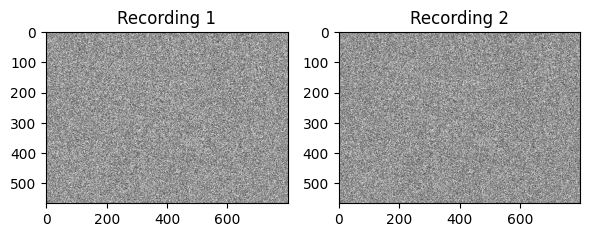

In [3]:
# display recordings
fig = plt.figure(figsize = (6,6))

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img1, cmap=cm.Greys_r)
plt.title("Recording 1")

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img2, cmap=cm.Greys_r)
plt.title("Recording 2")

plt.tight_layout()
plt.show()

In [4]:
# create data for ICA
x = np.array([img1, img2])
x.shape

(2, 567, 800)

In [5]:
class ICA():
    def __init__(self, x, **kwargs):
        self.n = kwargs.get('n', x.shape[1])
        self.m = kwargs.get('m', x.shape[2])
        self.alpha = kwargs.get('alpha', 1)
        self.max_iter = kwargs.get('max_iter', 1e4)
        self.G = kwargs.get('g', 1)
        self.means = None
        self.white_x = None
        self.s = None
        self.x = self.center(x) # pass in as np array of images in original shape
        self.w = self.init_w()


    def center(self, x):
        """center data by subtracting mean
        flattens into column vectors, subtracts mean across rows
        returns:
            centered_x: np.array of flattened images as column vectors, each column is an img
        """

        x = np.c_[img1.flatten(), img2.flatten()]
        self.means = np.mean(x, axis = 0, keepdims = True)
        centered_x = x - self.means

        return centered_x

    
    def init_w(self):
        """randomly initialize weights of mixing matrix
        l2 norm of weights must = 1
        returns:
            normalized weights of shape num imgs x num imgs
        """
        
        w = np.random.rand(self.x.shape[1], self.x.shape[1])
        return w / np.linalg.norm(w, 2)

    
    def g(self, u):
        """g function"""

        if self.G == 1:
            return -np.exp(-(u**2)/2)
        else:
            return 1/self.alpha * (np.log(np.cosh(self.alpha * u)))
            

    def g_prime(self, u):
        """derivative of g function"""

        if self.G == 1:
            return u * np.exp(-(u**2)/2)
        else:
            return np.tanh(self.alpha * u)


    def whiten(self):
        """performs whitening, data becomes uncorrelated and has unit variance (==1)
        gets eigen vecs and vals through svd
        SVD: X = USV^T (V is returned transposed by numpy)
        whitened data: X~ = E D^-1/2 E.T x (E = U, D = S)
        """

        cov_mat = self.x.T @ self.x
        U,S,V = np.linalg.svd(cov_mat, full_matrices = False)
        # check svd worked
        assert np.allclose(cov_mat, np.dot(U * S, V)), "covariance matrix was not reconstructed properly"

        D = np.linalg.inv(np.sqrt(np.diag(S)))
        x_tilde = U @ D @ U.T @ self.x.T
        # check x~ @ x~.T == I
        assert np.allclose(x_tilde@x_tilde.T, np.eye(self.x.shape[1])), "x~.T @ x~ != Identity"

        return x_tilde


    def fast_ica(self):
        """iterates through rows of weight vector updating weights until convergence
        convergence = w.T @ w =~ 1 due to normalization of w
        after convergence signals are recovered S = WX
        the mean of the centered data is added to the signal
        """

        self.white_x = self.whiten()

        for i in range(self.w.shape[0]):
            w = self.w[i].copy()

            c = 0
            status = 0
            while status == 0:
                status, w_new = self.update_w(w)
                w = w_new
                c += 1
                if c > self.max_iter:
                    print('FastICA failed to converge within max iterations')
                    break
        # add back the mean of the data to the signal that is recovered after finding W
        # S = WX + E{X}
        self.s = self.w @ self.white_x + self.means.T


    def update_w(self, w):
        """updates and normalizes weights"""

        # copy weights as they'll be changing
        w_prev = w.copy()
        # compute wTx for shorter code below
        wtx = w.T @ self.white_x
        # compute w+
        w_plus = np.mean(self.white_x * self.g(wtx)) - (np.mean(self.g_prime(wtx)) * w)
        # normalize w+ and set as new weights
        w = w_plus / np.linalg.norm(w_plus, 2)

        # check if wT@w == 1 then converged
        w_old_dot_w_new = w_prev.T @ w
        if np.allclose(w_old_dot_w_new, 1):
            return 1, w
        else:
            return 0, w


    def show_img(self):
        """displays signals with noise removed"""
        
        signals = {}
        for i in range(self.s.shape[0]):
            signals[f"s{i+1}"] = self.s[i].reshape(self.n, self.m)

        fig = plt.figure(figsize = (6,6))

        num_plots = self.s.shape[0]
        for i in range(num_plots):
            ax = fig.add_subplot(1,num_plots,i+1)
            ax.imshow(signals[f"s{i+1}"], cmap=cm.Greys_r)
            plt.title(f"Signal {i+1}")

        plt.tight_layout()
        plt.show()

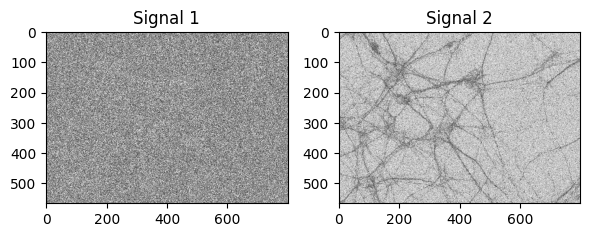

In [12]:
ica = ICA(x)
ica.fast_ica()
ica.show_img()

### Summary:

Given two recordings we were able to separate signals and display both the underlying image and the noise that was added using the Fast ICA algorithm. Rerunning the code produces slightly different images each time as we can see below. This is due to the fact that we cannot recover the sequence of signals.

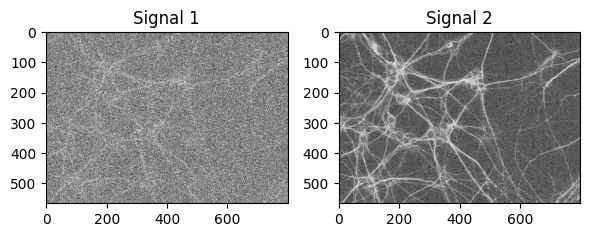

In [15]:
# using other function for G
ica2 = ICA(x, g = 2)
ica2.fast_ica()
ica2.show_img()